# Analyzing returns of an LSTM model trained on bitcoin
First gather data, train the model, and evaluate it compared to an ARMA model and a random strategy on common quant metrics.

As data source, I will be using "tiingo".

See [the documentation](https://api.tiingo.com/documentation/crypto) of the API.

In [1]:
import requests
import pandas as pd

params = {
    "token": "3780b5d18a15253a9e1d33d483ad4dccd49ae20e",
    "startDate": "2020-01-01",
    "endDate": "2022-12-31",
    "tickers": "btcusd",
    "resampleFreq": "1day",
}
headers = {'Content-Type': 'application/json'}

url = "https://api.tiingo.com/tiingo/crypto/prices"
response = requests.get(url, headers=headers, params=params)
data = response.json()
df = pd.DataFrame(data[0]['priceData'])
df = df[['date', 'close', 'volumeNotional']]
df.rename(columns={'volumeNotional': 'volume'}, inplace=True)
df['date'] = pd.DatetimeIndex(df['date'], freq='D').date
df.set_index(['date'], inplace=True)
df.head()

,close,volume
date,,
2020-01-01,7196.776430,1.690488e+08
2020-01-02,6963.684559,3.256220e+08
2020-01-03,7345.355821,6.763888e+08
2020-01-04,7354.871466,3.007702e+08
2020-01-05,7358.496281,3.759023e+08


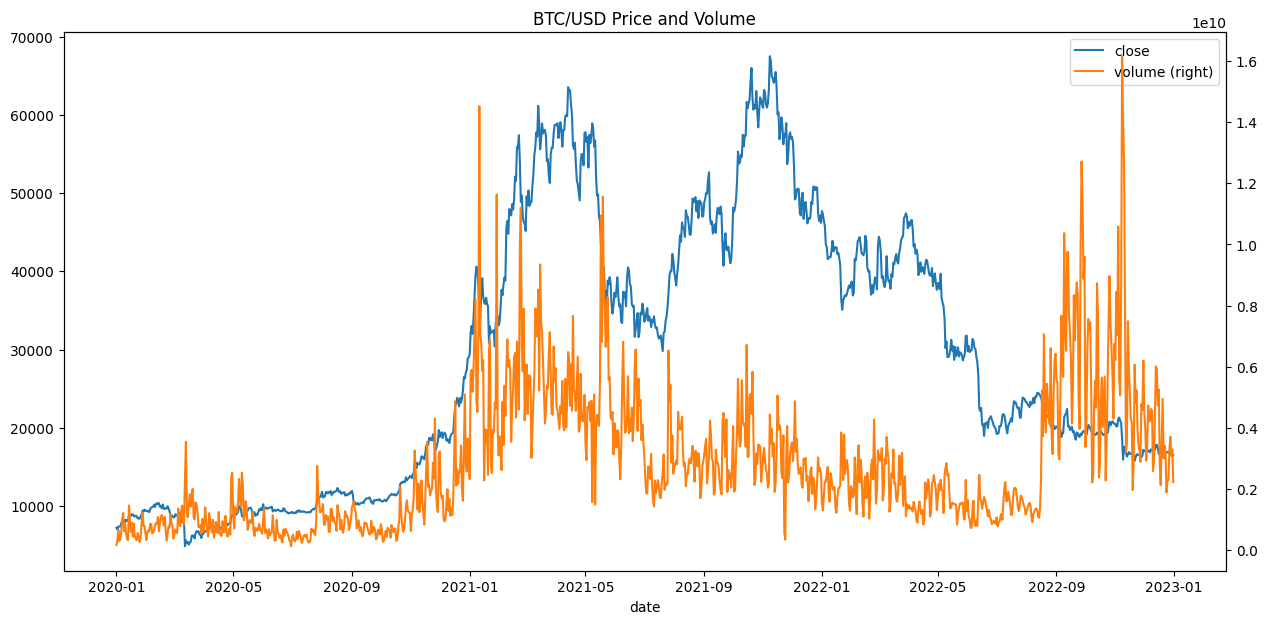

In [2]:
# take a look at the historical price data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))
df.plot(y='close', ax=ax)
df.plot(y='volume', ax=ax, secondary_y=True)
plt.title("BTC/USD Price and Volume")
plt.show()

Consistent volatility and mean is preferred to predict accurately, so try to predict the returns rather than price.

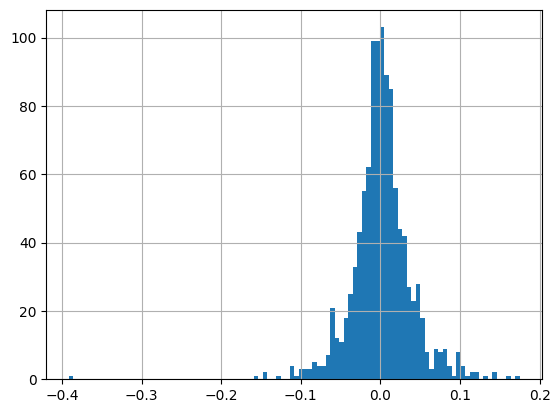

In [3]:
df['returns'] = df['close'].pct_change().fillna(0)
df['returns'].hist(bins=100)
plt.show()

## Train Test Split

At this point we should set aside a test dataset and never look at it until the very end of the journey in order to make sure we don't notice any patterns biasing our predictions.

Hopefully we don't remember anything from the two graphs above. It probably would be better to have done this before looking at those graphs.

Let anything before 2021 and 2022 be our training set, and 2022 be our test dataset.

Furthermore, we will seperate the training set into a training and validation set. For simplicity, let 2021 be our training set and 2022 be our validation set. This way we can evaluate the actual capacity of our models to fit the data without too much fear of overfitting, since the validation score should be relatively similar to the final test score, at least prior to hyperparameter optimization.

In many cases, it would be better to use k-fold cross-validation to reduce our chance of overfitting, and get a more realistic validation score. This means we would take a portion of our training set k times to train and evaluate on the unused portion, then average the scores. 

In the time series case, cross-validation will look something like this:
<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*qvdnPF8ETV9mFdMT0Y_BBA.png" alt="Cross Validation Image" />
</p>

In [4]:
from datetime import date
test_df = df.loc[df.index >= date(2022,1,1)].copy()
train_df = df.loc[df.index < date(2021,1,1)].copy()
valid_df = df.loc[(df.index >= date(2021, 1, 1)) & (df.index < date(2022, 1, 1))].copy()
train_df.tail()

,close,volume,returns
date,,,
2020-12-27,26306.962487,5.098536e+09,-0.006629
2020-12-28,27070.992204,2.829640e+09,0.029043
2020-12-29,27375.298685,2.580599e+09,0.011241
2020-12-30,28879.329401,3.651053e+09,0.054941
2020-12-31,28975.354407,3.143108e+09,0.003325


## Baseline Model
For the baseline model, create a random signal.

Each day we want a value between -1 and 1, which indicates that portion of our assets that will be used to buy or sell the instrument.

In [5]:
import numpy as np
df['random'] = np.random.uniform(-1, 1, len(df))
df['random'].head()

date
2020-01-01   -0.869147
2020-01-02   -0.975081
2020-01-03   -0.880107
2020-01-04    0.810334
2020-01-05    0.334220
Name: random, dtype: float64

Now we need to run a vectorized simulation of the result should we actually have used the generated strategy.

For simplicity, suppose we start with exactly 1usd, there are no trading fees, and partial buying is possible at infinitely small portions.

We can acheive this by taking the strategy's suggested position and multiplying by the instrument's returns.

We will call the new column 'pnl' for 'profit and loss'.

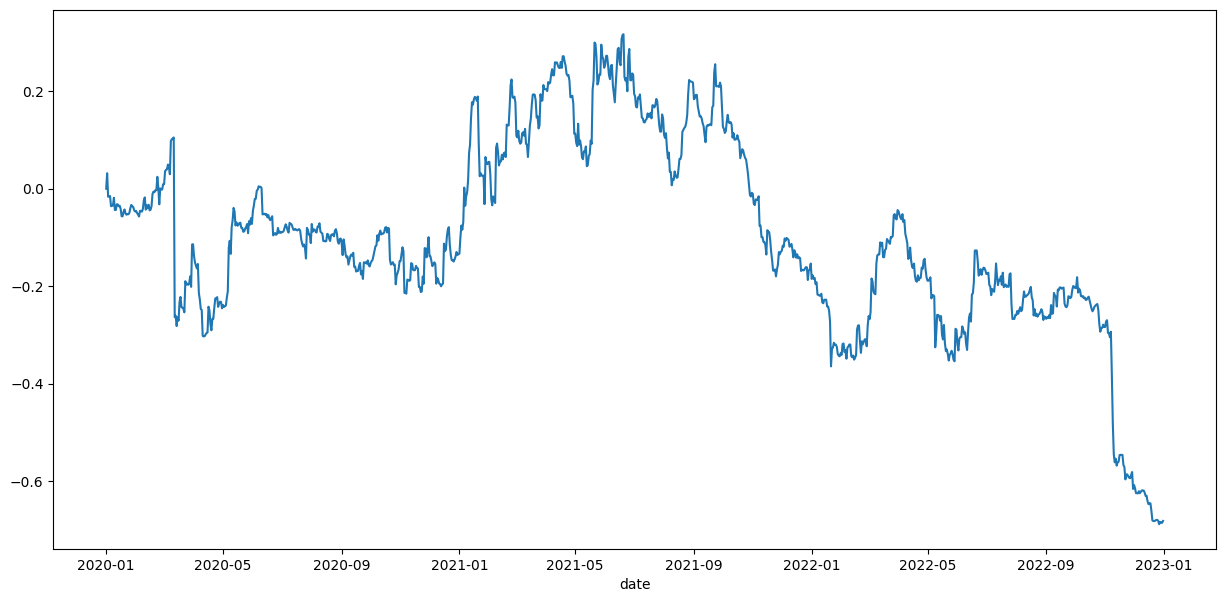

-0.6817827944658332

In [6]:
plt.figure(figsize=(15, 7))
df['random_pnl'] = df['random'] * df['returns']
df['random_pnl'].cumsum().plot()
plt.show()

df['random_pnl'].sum()

The returns vary wildly and give a slightly negative result, as expected of a random strategy. Should we have run this strategy with 1 usd for the two years, we would have ended up with $0.97.

Note that simply considering the predicted return does not show the risk of the strategy. To do that, we will also consider the variance of the returns later. See the metrics portion of the notebook after we have predictions for the other models. Let's also randomly predict some values for the test set.

In [7]:
test_df['random'] = np.random.uniform(-1, 1, len(test_df))
test_df['random_pnl'] = test_df['random'] * test_df['returns']
test_df['random_pnl'].sum()

-0.322496901093685

## ARMA Model

Now we will improve our model by creating one based on the [autoregressive-moving-average model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model), or "ARMA model" for short.

The ARMA model can be described by the following equation:

$$
X_t = \sum_{i=1}^{p} \phi_i X_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t
$$

where p represents the order of the autoregressive part and q represents the order of the moving average part.

Now let's train our ARIMA model. We will begin by investigating the autocorrelation and partial autocorrelation plots to see what kind of model we should use based on the [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method#Autocorrelation_and_partial_autocorrelation_plots).

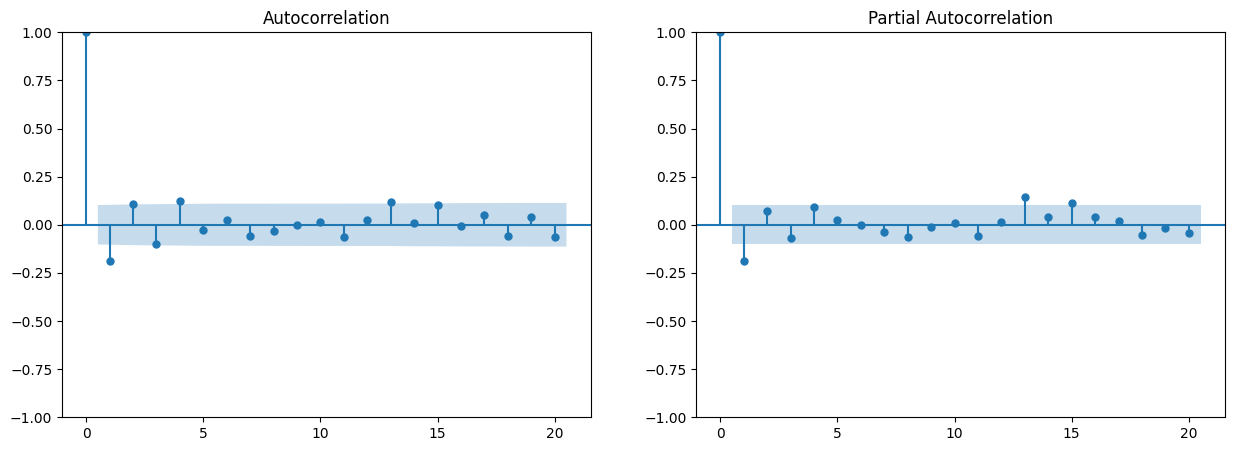

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(train_df['returns'], lags=20, ax=ax[0])
plot_pacf(train_df['returns'], lags=20, ax=ax[1])
plt.show()

Notice the strongest signals are at 1 day and 4 days in both the autocorrelation and partial autocorrelation plots. This would inform us to use order 4 for both parameters, or perhaps 1 for the autoregressive part and 4 for the moving average part. There also seems to be an interesting value on the 13th day, so maybe that for the moving average. They aren't really that strong so the results might not be so good.

First let's create a base model without choosing parameters based on the Box-Jenkins method.

While we are at it, let's define a graphing function to help us know when our model is buying and selling, since we will be doing that a lot.

In [9]:
def plot_pnl(pnl, signal, closing_price, title, figsize=(15, 7)):
    plt.figure(figsize=figsize)
    pnl.cumsum().plot(label="Cumulative PnL", color='blue', alpha=0.9)
    closing_price.plot(label="Closing Price", color='black', alpha=.5, secondary_y=True)
    plt.title(title)
    for i in range(len(signal)):
        if signal[i] < -.3:
            plt.axvline(x=signal.index[i], color='red', linestyle='--', alpha=0.2)
        elif signal[i] > .3:
            plt.axvline(x=signal.index[i], color='green', linestyle='--', alpha=0.2)
    plt.legend()
    plt.show()

We also need a more complicated method for predicting returns by incorporating new data into our predictions, similar to how we would actually use it for trading. Vectorization is not always easy.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

def min_max_scale(arr):
    # Find the minimum and maximum values in the array
    min_val = np.min(arr)
    max_val = np.max(arr)

    # Handle the case where the array has only non-negative or non-positive values
    if min_val >= 0 or max_val <= 0:
        return arr / max_val if max_val != 0 else arr / (min_val + 1e-8)

    # Separate the positive and negative values in the array
    pos_values = arr[arr >= 0]
    neg_values = arr[arr < 0]

    # Min-max scale positive values
    scaled_pos = (pos_values - min_val) / (max_val - min_val)

    # Min-max scale negative values
    scaled_neg = (neg_values - min_val) / (min_val - max_val)

    # Combine the scaled positive and negative values back into the original array
    scaled_arr = np.zeros_like(arr)
    scaled_arr[arr >= 0] = scaled_pos
    scaled_arr[arr < 0] = scaled_neg

    return scaled_arr

def calc_arima_pnl(order=(1,0,0), set='valid'):
    prediction = pd.Series()
    initial_data = train_df['returns'].copy()
    data = valid_df['returns']
    if set == 'test':
        initial_data = valid_df['returns'].copy()
        data = test_df['returns']
    model = ARIMA(initial_data, order=order, freq='D').fit()
    for i in range(len(data)):
        # Predict
        pred = model.forecast()
        prediction = pd.concat([prediction, pred])

        # Update data
        initial_data.at[data.index[i]] = data[i]

        # Update model
        model = ARIMA(initial_data, order=order, freq='D').fit()
    prediction.index = prediction.index.to_series().dt.date
    # Min-max scale the predictions
    prediction = min_max_scale(prediction)
    pnl = prediction * valid_df['returns']
    if set == 'test':
        pnl = prediction * test_df['returns']
    return prediction, pnl

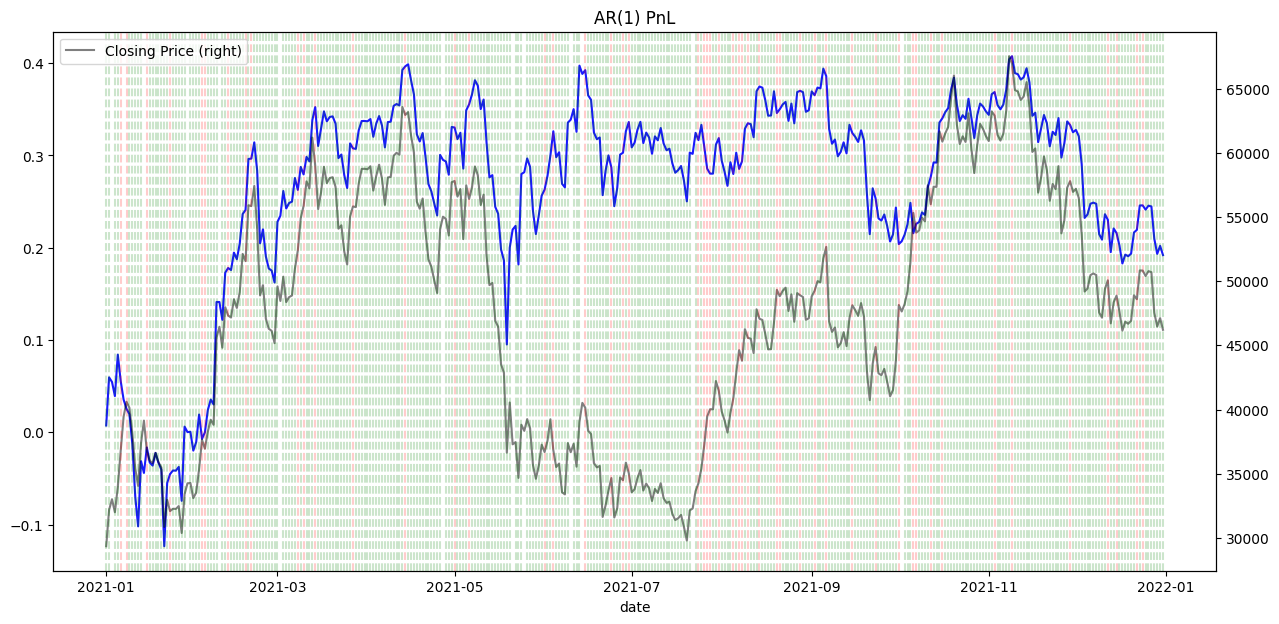

0.1920256209755352

In [11]:
valid_df['ar1'], valid_df['ar1_pnl'] = calc_arima_pnl(order=(1,0,0))
plot_pnl(valid_df['ar1_pnl'], valid_df['ar1'], valid_df['close'], "AR(1) PnL")
valid_df['ar1_pnl'].sum()

The result is better than the random strategy. We would have ended up with $1.276.

We could also try implementing a threshhold, such that we don't bother doing anything unless the signal has a certain confidence level. Let's try that now.

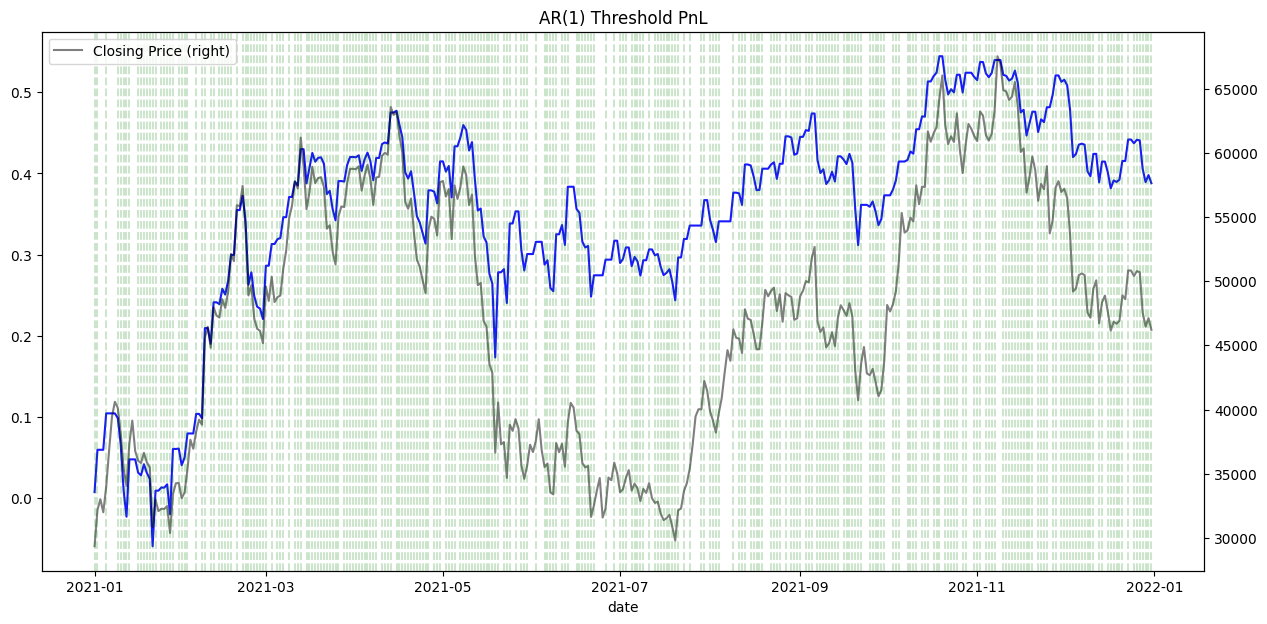

0.38796826158257963

In [12]:
valid_df['ar1_threshold'] = valid_df['ar1'].apply(lambda x: x if abs(x) > .5 else 0)
valid_df['ar1_threshold_pnl'] = valid_df['ar1_threshold'] * valid_df['returns']
plot_pnl(valid_df['ar1_threshold_pnl'], valid_df['ar1_threshold'], valid_df['close'], "AR(1) Threshold PnL")
valid_df['ar1_threshold_pnl'].sum()

The total profit went down, but trading less is a good thing in practice as trading isn't free. Later we will have some metrics to quantify that.

Now let's try some better parameters that we inferred from our autocorrelation and partial autocorrelation graphs from earlier.

We will try 4-0, 4-1, 4-4, and 4-13 to see what gives the best result.

In [37]:
orders = [(1,0,0), (4, 0, 0), (4, 0, 1), (4, 0, 4), (4, 0, 13)]
for order in orders:
    valid_df[f'arma_{order}'], valid_df[f'arma_{order}_pnl'] = calc_arima_pnl(order=order)
    print(f"ARMA{order} PnL: {valid_df[f'arma_{order}_pnl'].sum()}")

ARMA(1, 0, 0) PnL: 0.7491056705685103
ARMA(4, 0, 0) PnL: 0.35385754973962524
ARMA(4, 0, 1) PnL: 0.27273755286823237
ARMA(4, 0, 4) PnL: 0.5474166187606397
ARMA(4, 0, 13) PnL: 0.575496325202884


The best result is given by (1, 0, 0), but (4, 0, 4) and (4, 0, 13) also give nice results. (1, 0, 0) is the least complex model, so let's choose that for our test set as it is less likely to overfit.

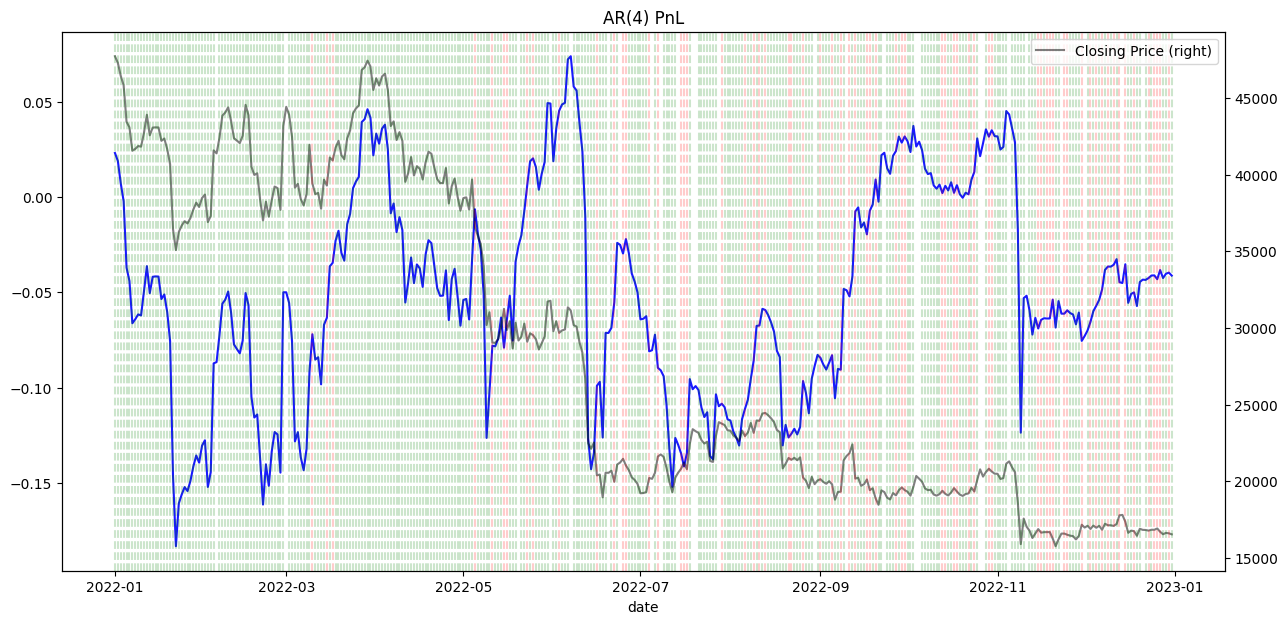

-0.04126960848776818

In [49]:
test_df['arma'], test_df['arma_pnl'] = calc_arima_pnl(order=(1, 0, 0), set='test')
plot_pnl(test_df['arma_pnl'], test_df['arma'], test_df['close'], "AR(4) PnL")
test_df['arma_pnl'].sum()

It performed way worse on the test set. The characteristics of the signal may have changed, or our model may just not be suited for the task. Let's also store a threshold capped model in the test set for analysing later.

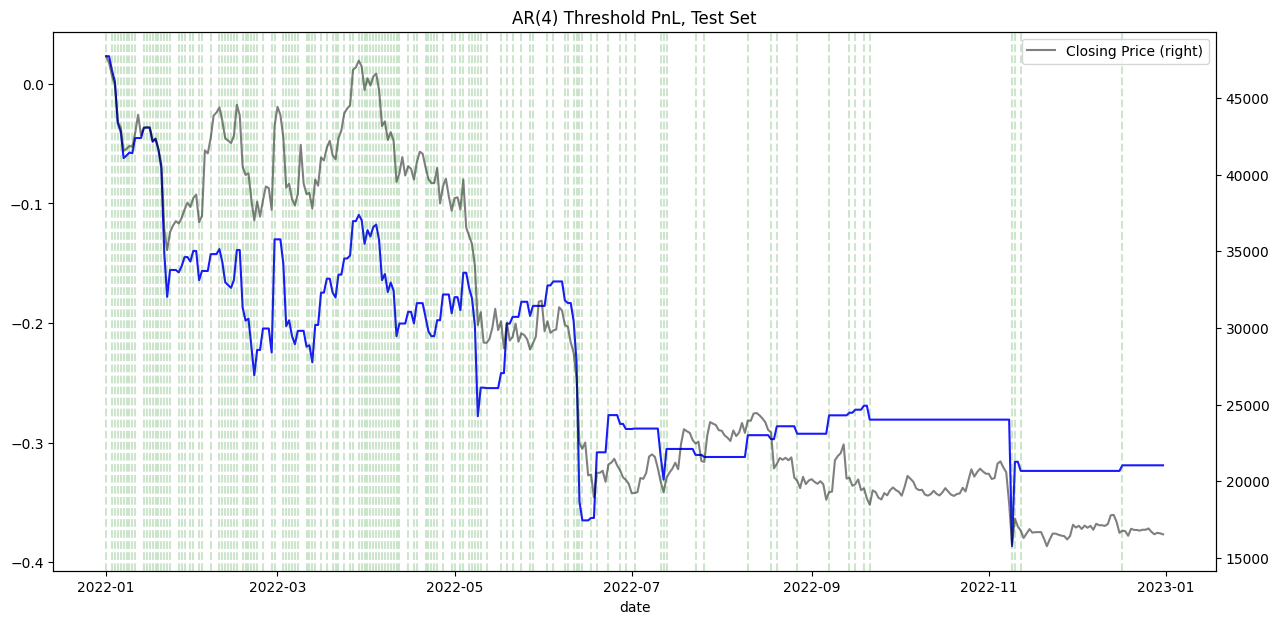

-0.31907205766704655

In [14]:
test_df['arma_threshold'] = test_df['arma'].apply(lambda x: x if abs(x) > .5 else 0)
test_df['arma_threshold_pnl'] = test_df['arma_threshold'] * test_df['returns']
plot_pnl(test_df['arma_threshold_pnl'], test_df['arma_threshold'], test_df['close'], "AR(4) Threshold PnL, Test Set")
test_df['arma_threshold_pnl'].sum()

## LSTM Model

Now we implement the [Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory) model.

We will be using the LSTM model available in keras to implement. First import the necessary modules.

In [15]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

First, we should scale the features since neural networks generally perform better on scaled features (all values between 0 and 1).
We will also generate sequences for the LSTM, so it knows what the values from the past several days are. Initially, we will make this 10 days.

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['close_sc', 'volume_sc']] = scaler.fit_transform(df[['close', 'volume']])

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length+1]  # Include the next value as the target
        sequences.append(sequence)
    return sequences

sequence_length = 10
sequences = create_sequences(df[['close_sc', 'volume_sc', 'returns']].values, sequence_length)
sequences = np.array(sequences)

X = sequences[:, :-1, :-1]
y = sequences[:, -1, -1]
X.shape, y.shape

((1086, 10, 2), (1086,))

In [47]:
X_train = X[:356]
y_train = y[:356]
X_valid = X[356:721]
y_valid = y[356:721]
X_test = X[721:]
y_test = y[721:]

X_valid.shape, y_valid.shape

((365, 10, 2), (365,))

First try a simple model with one LSTM layer of 32 units and an output layer to get a baseline. We can then adjust the layers to see what scores better on the validation set, and use the best parameters for our final model. We will use price and volume data to predict the price of the next day, so our input shape is 2.

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4480      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4513 (17.63 KB)
Trainable params: 4513 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The number of trainable parameters is quite high! This leads to believe a lot of data would be required to train the parameters well.

In [19]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 11/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 13/50
12/12 [==============================

12/12 [==============================] - 0s 2ms/step


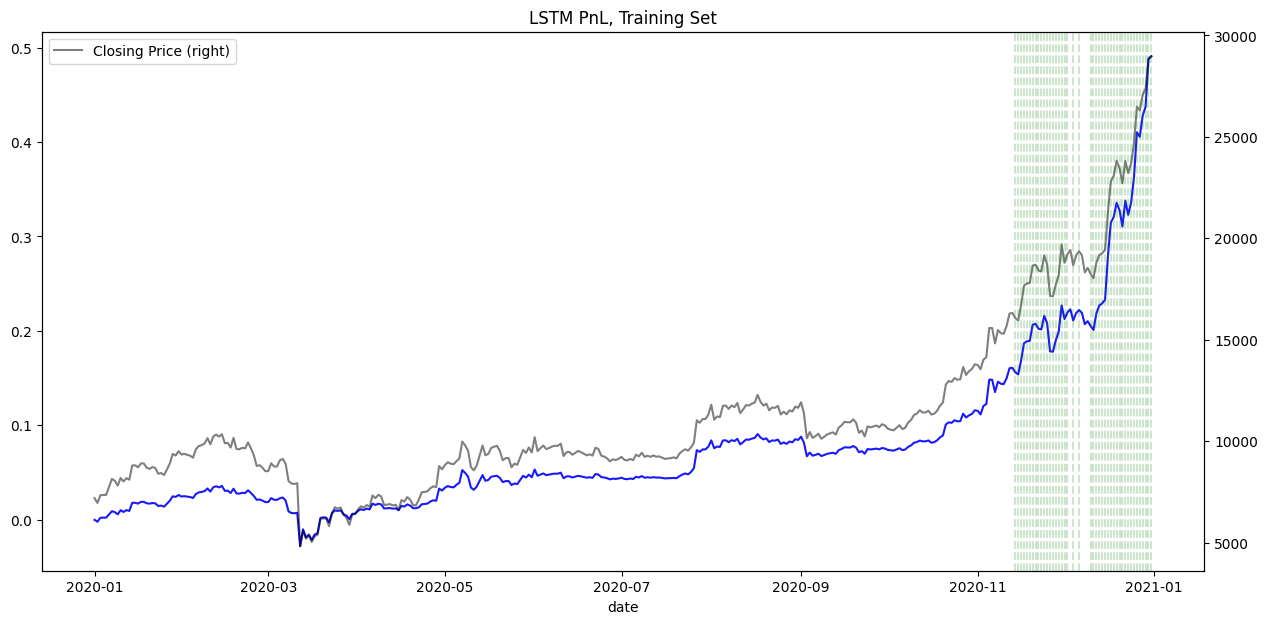

0.49078121971781885

In [20]:
train_df['lstm'] = np.insert(min_max_scale(model.predict(X_train)), 0, 0)
train_df['lstm_pnl'] = train_df['lstm'] * train_df['returns']
plot_pnl(train_df['lstm_pnl'], train_df['lstm'], train_df['close'], "LSTM PnL, Training Set")
train_df['lstm_pnl'].sum()

12/12 [==============================] - 0s 2ms/step


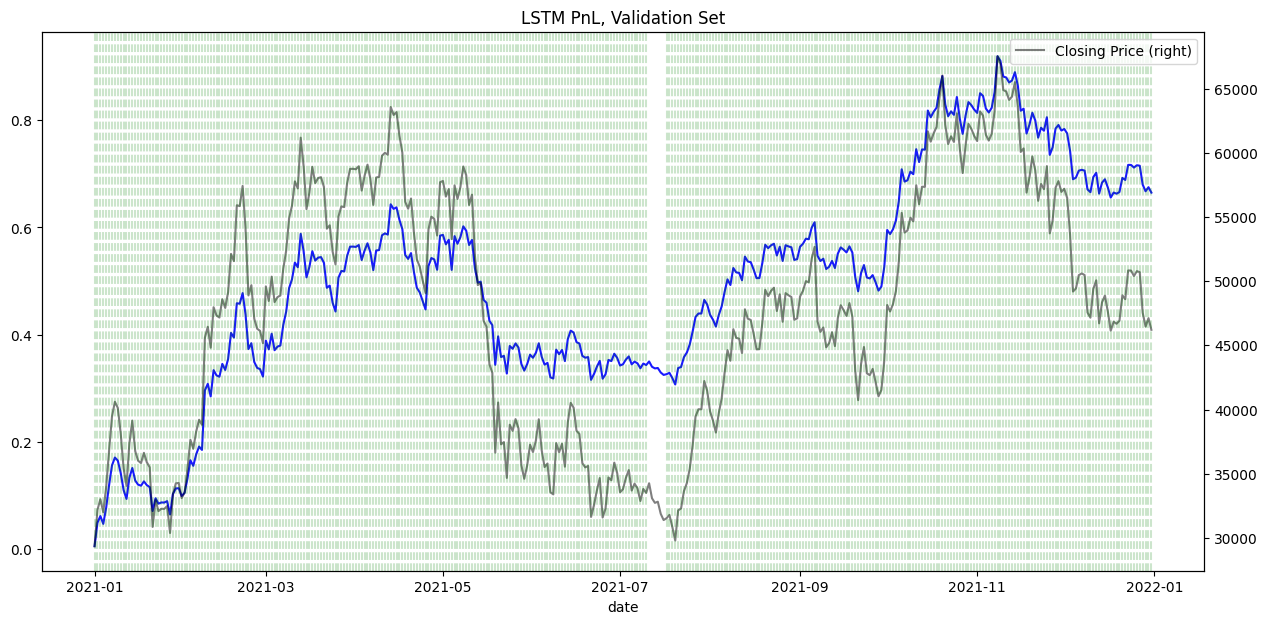

0.6648278469665558

In [22]:
valid_df['lstm_1'] = min_max_scale(model.predict(X_valid)[:,0])
valid_df['lstm_1_pnl'] = valid_df['lstm_1'] * valid_df['returns']
plot_pnl(valid_df['lstm_1_pnl'], valid_df['lstm_1'], valid_df['close'], "LSTM PnL, Validation Set")
valid_df['lstm_1_pnl'].sum()

It did quite well!

It performed much better on the training set than the validation set. That would indicate that our model is overfitting. Perhaps adding a [dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)) layer would make the model more robust. This works by randomly removing some connections during training so that the model cannot rely too much on specific nodes. An analogy is if you had a company and randomly had some workers not come to work each day, everyone would have to learn to not rely on anyone in particular for a certain task. 
<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1044/1*iWQzxhVlvadk6VAJjsgXgg.png" alt="Dropout" />
</p>

Let's implement a layer that drops 15% of the connections randomly and see if that helps at all.

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                4480      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4513 (17.63 KB)
Trainable params: 4513 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


12/12 [==============================] - 0s 2ms/step


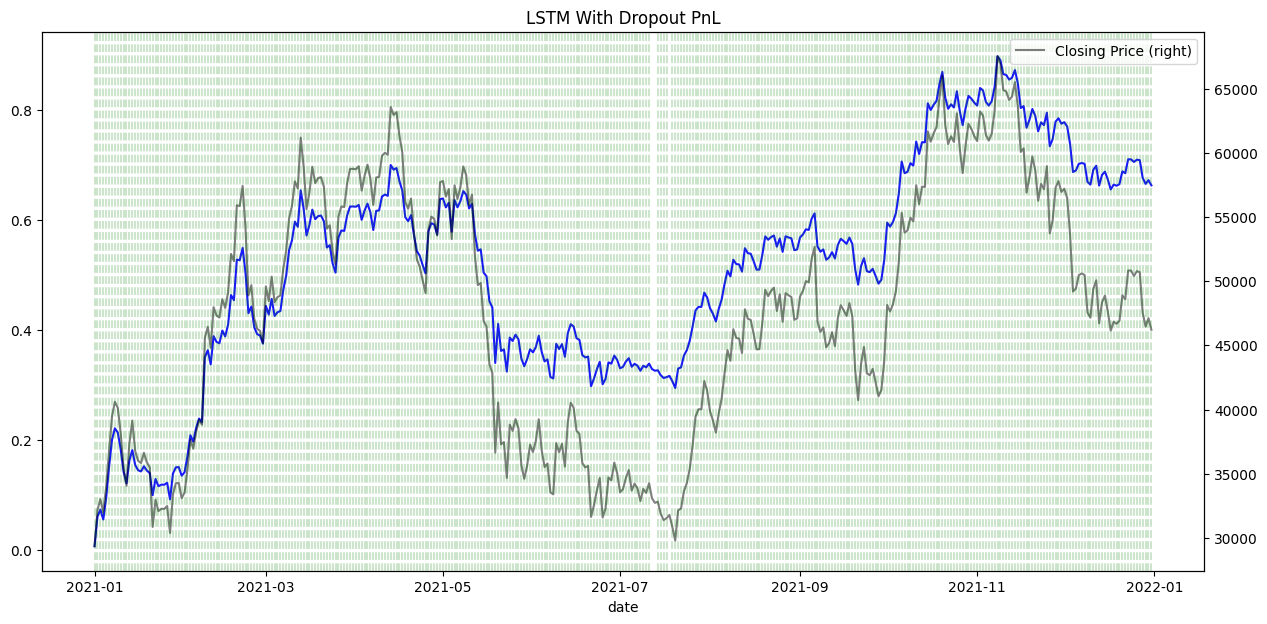

0.6627095062891388

In [33]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
valid_df['lstm_2'] = min_max_scale(model.predict(X_valid)[:,0])
valid_df['lstm_2_pnl'] = valid_df['lstm_2'] * valid_df['returns']
plot_pnl(valid_df['lstm_2_pnl'], valid_df['lstm_2'], valid_df['close'], "LSTM With Dropout PnL")
valid_df['lstm_2_pnl'].sum()

It did very well! Let's try making the model really simple by reducing our layers to 8 and see what happens. Let's reduce the dropout to 10% as well.

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 8)                 352       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


12/12 [==============================] - 0s 2ms/step


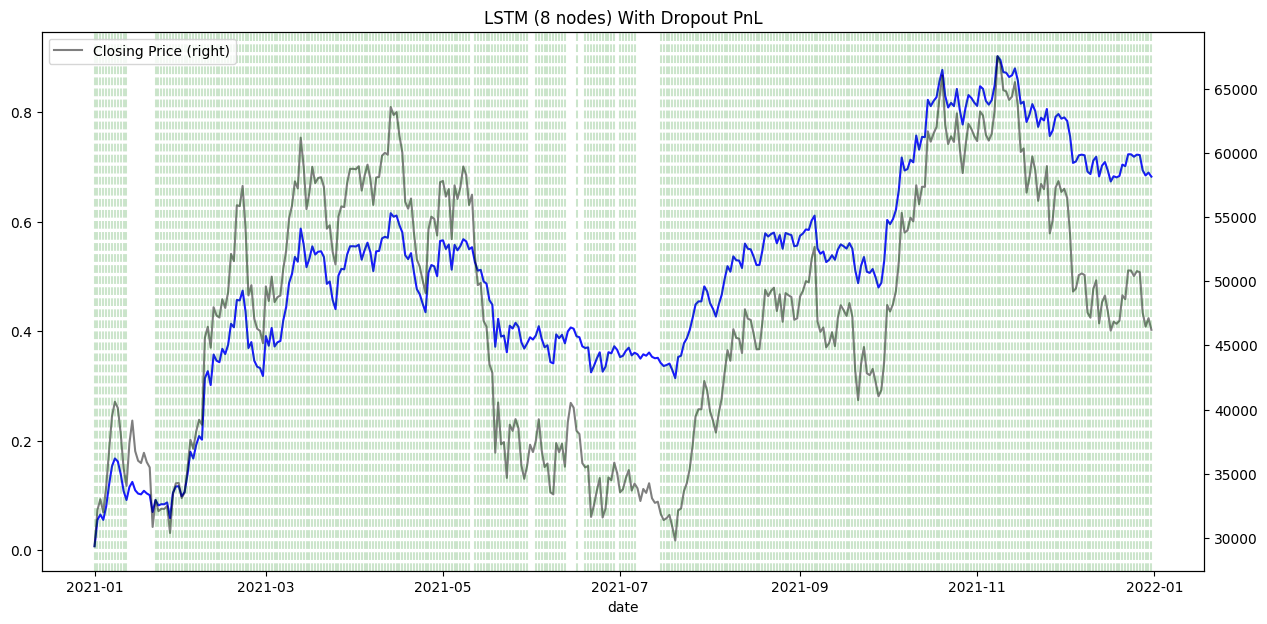

0.682312153964213

In [35]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
valid_df['lstm_3'] = min_max_scale(model.predict(X_valid)[:,0])
valid_df['lstm_3_pnl'] = valid_df['lstm_3'] * valid_df['returns']
plot_pnl(valid_df['lstm_3_pnl'], valid_df['lstm_3'], valid_df['close'], "LSTM (8 nodes) With Dropout PnL")
valid_df['lstm_3_pnl'].sum()

It performed much worse! Maybe 8 nodes was not enough. Now let's try making it really complicated just to see what happens.

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 10, 32)            4480      
                                                                 
 dropout_12 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_14 (LSTM)              (None, 10, 32)            8320      
                                                                 
 dropout_13 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_15 (LSTM)              (None, 10, 32)            8320      
                                                                 
 dropout_14 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_16 (LSTM)              (None, 10, 32)           

12/12 [==============================] - 2s 6ms/step


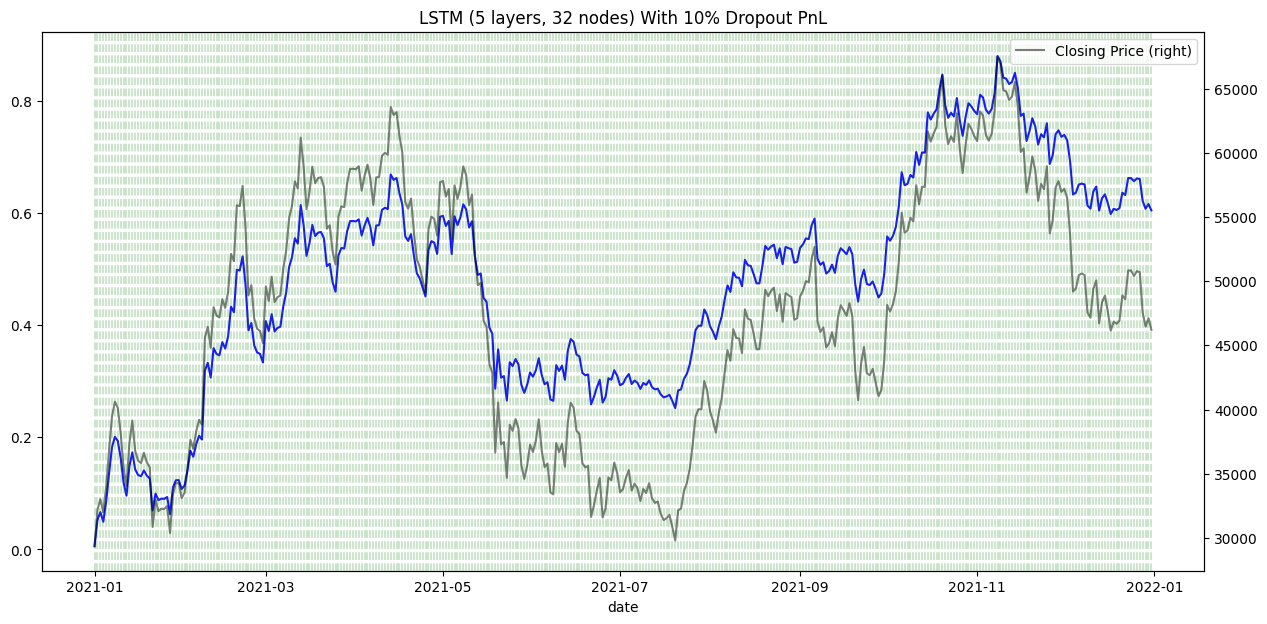

0.604829772051708

In [37]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
valid_df['lstm_4'] = min_max_scale(model.predict(X_valid)[:,0])
valid_df['lstm_4_pnl'] = valid_df['lstm_4'] * valid_df['returns']
plot_pnl(valid_df['lstm_4_pnl'], valid_df['lstm_4'], valid_df['close'], "LSTM (5 layers, 32 nodes) With 10% Dropout PnL")
valid_df['lstm_4_pnl'].sum()

It's quite good! Similar to our first results. And for one final iteration, let's try many layers and few nodes.

12/12 [==============================] - 3s 6ms/step


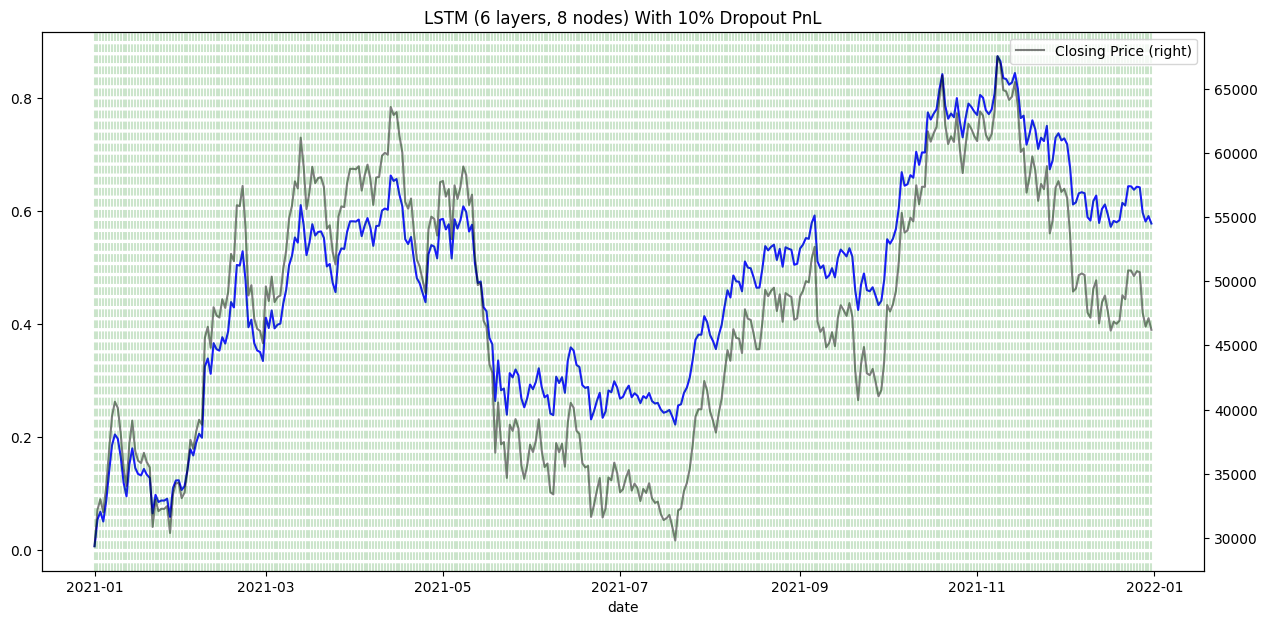

0.5773241194118209

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(8, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(8, return_sequences = True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(8, return_sequences = True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(8, return_sequences = True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(8, return_sequences = True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
valid_df['lstm_5'] = min_max_scale(model.predict(X_valid)[:,0])
valid_df['lstm_5_pnl'] = valid_df['lstm_5'] * valid_df['returns']
plot_pnl(valid_df['lstm_5_pnl'], valid_df['lstm_5'], valid_df['close'], "LSTM (6 layers, 8 nodes) With 10% Dropout PnL")
valid_df['lstm_5_pnl'].sum()

Not that bad! We've iterated enough, let's make a choice for our final model. Our model with 15% dropout and one LSTM layer performed quite well for it's simplicity, so let's go with that for our final choice to use on the test set. Now let's make predictions for the test set.

12/12 [==============================] - 0s 2ms/step


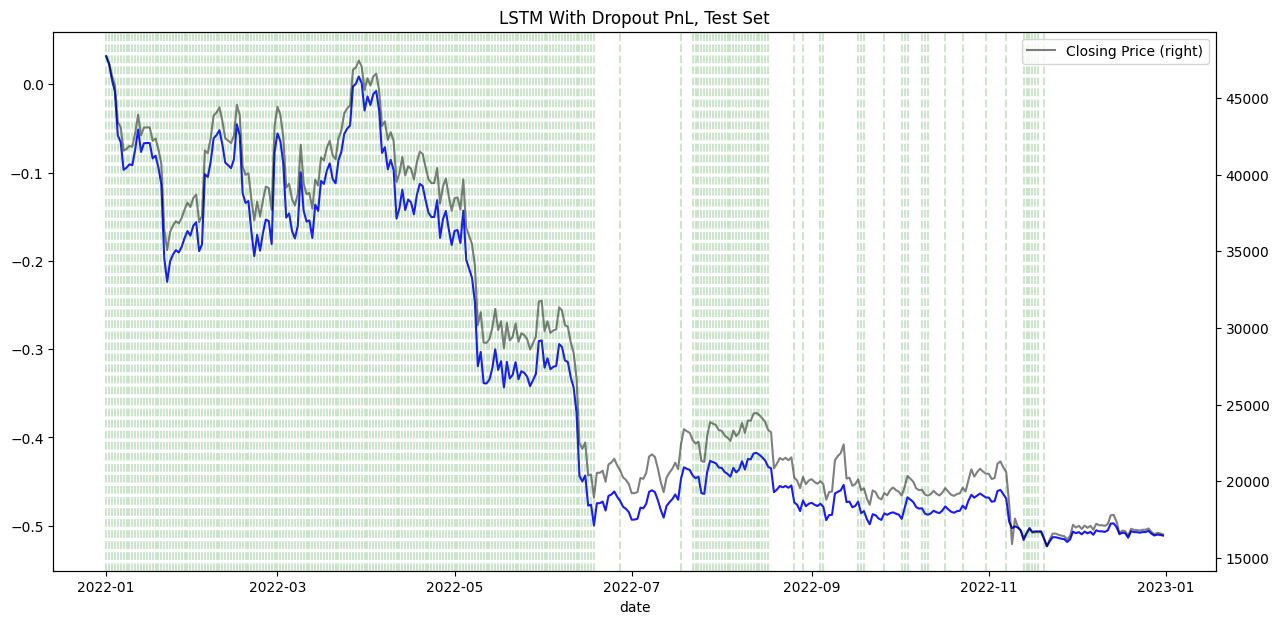

-0.5110970399142061

In [48]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
test_df['lstm'] = min_max_scale(model.predict(X_test)[:,0])
test_df['lstm_pnl'] = test_df['lstm'] * test_df['returns']
plot_pnl(test_df['lstm_pnl'], test_df['lstm'], test_df['close'], "LSTM With Dropout PnL, Test Set")
test_df['lstm_pnl'].sum()

In the end, the model performed very badly on the test set, similar to our ARMA model. Most likely this is a result of the change in characteristics of how BTC traded in 2020, 2021, and 2022. First, let's introduce some metrics to measure just how much our models sucked compared to each other.

## Metrics

The most intuitive metric is one we have already been using the whole time-- profit and loss. However, this does not encapsulate other factors that someone actually trading would be interested in, namely risk and trading costs. It doesn't matter if the model could potentially make a lot of money, if it is equally likely to lose a lot of money. We will attempt to measure risk with a more comprehensive metric known as the sharpe ratio. Formally, it is the "information ratio" multiplied by the square root of the number of trading days, in our case 365, where the information ratio is the pnl minus the "risk free return" divided by the standard deviation of the pnl. Intuitively, a lower variance in the returns means lower risk. The risk free return is theoretically the return you could acheive with 100% certainty. In reality, such a thing does not exist, but government bonds rates are used as good enough. Since we are only comparing models against each other, let's simply assume it to be 0.

$Information Ratio = \frac{R_p - R_f}{\sigma_p}$

$Sharpe Ratio = Information Ratio \cdot \sqrt{365}$

To evaluate the total trading activity of each strategy, we can evaluate the [turnover](https://www.investopedia.com/terms/p/portfolioturnover.asp) of each strategy during the testing period. Turnover refers to the amount of trading relative to the value of an asset, expressed as a percentage. Mathematically, it could be described as follows.

$Turnover = \frac{\text{Total Value of Transactions}}{\text{Initial Value of Portfolio}} \cdot 100$

Intuitively, a lower turnover means we incur less trading fees. In our case, with a portfolio of 1, calculation is quite simple.

Margin is a metric that assesses the profitability of a strategy, also known as "profit margin". It is calculated as the net profit of the strategy divided by the total trading volume, to show how much profit we are able to return per dollar spent on the strategy. It is particularly useful when using leverage to magnify returns on strategies, to get the highest return per money borrowed. In our case, we probably wouldn't want to use leverage on any strategy since they all lose money, but nonetheless we shall calculate it.

$\text{Margin} = \frac{\text{Net Profit}}{\text{Trading Volume}} \cdot 100$

Finally, let's calculate the fitness ratio, which could be considered an all encompassing metric to determine the efficiency of a strategy by considering risk, turnover, and profitability. We compute it by the sharpe ratio multiplied by net profit, divided by the turnover.

$ \text{Fitness Ratio} = \frac{\text{Sharpe Ratio} \cdot \text{Net Profit}}{\text{Turnover}} $

Let's calculate each for our random strategy, ARIMA strategy, and LSTM strategy.

In [50]:
test_df.head()

,close,volume,returns,random,random_pnl,arma,arma_pnl,arma_threshold,arma_threshold_pnl,lstm,lstm_pnl
date,,,,,,,,,,,
2022-01-01,47728.404987,1.549540e+09,0.032774,0.366537,0.012013,0.704642,0.023094,0.704642,0.023094,0.966166,0.031665
2022-01-02,47291.603462,1.306250e+09,-0.009152,-0.606758,0.005553,0.454096,-0.004156,0.000000,-0.000000,0.989640,-0.009057
2022-01-03,46449.647765,1.801181e+09,-0.017803,-0.041361,0.000736,0.661558,-0.011778,0.661558,-0.011778,1.000000,-0.017803
2022-01-04,45827.679380,2.246707e+09,-0.013390,-0.847182,0.011344,0.699152,-0.009362,0.699152,-0.009362,0.982082,-0.013150
2022-01-05,43446.051028,2.249847e+09,-0.051969,-0.662029,0.034405,0.672020,-0.034924,0.672020,-0.034924,0.954780,-0.049619


In [69]:
models = ['random', 'arma', 'arma_threshold', 'lstm']
metric_names = ['pnl', 'ir', 'sharpe', 'trading_volume', 'turnover', 'margin', 'fitness']
metrics = pd.DataFrame(columns=models, index=metric_names)
for model in models:
    metrics.loc['pnl', f'{model}'] = test_df[f'{model}_pnl'].sum()
    metrics.loc['ir', f'{model}'] = test_df[f'{model}_pnl'].sum() / test_df[f'{model}_pnl'].std()
    metrics.loc['sharpe', f'{model}'] = metrics.loc['ir', f'{model}'] * sqrt(365)
    metrics.loc['trading_volume', f'{model}'] = test_df[f'{model}'].diff().abs().sum()
    metrics.loc['turnover', f'{model}'] = 100 * metrics.loc['trading_volume', f'{model}'] / (365 * 2)
    metrics.loc['margin', f'{model}'] = 100 * metrics.loc['pnl', f'{model}'] / metrics.loc['trading_volume', f'{model}']
    metrics.loc['fitness', f'{model}'] = metrics.loc['sharpe', f'{model}'] * (abs(metrics.loc['pnl', f'{model}']) / metrics.loc['turnover', f'{model}'])**0.5
metrics

,random,arma,arma_threshold,lstm
pnl,-0.322497,-0.04127,-0.319072,-0.511097
ir,-18.28842,-2.23643,-20.558294,-28.454598
sharpe,-349.399772,-42.72694,-392.76565,-543.624338
trading_volume,248.666174,125.643785,76.322533,8.178682
turnover,34.063859,17.211477,10.455141,1.120367
margin,-0.129691,-0.032847,-0.418057,-6.249137
fitness,-33.996833,-2.092223,-68.61403,-367.172659


## Conclusion

We begin to see a more complete picture. Although our LSTM model lost a lot of money, even compared to the random strategy, it traded far less. It saw our lowest turnover of 1.12, while the random strategy recorded a massive turnover of 34. Similarly the ARMA threshold strategy traded less than the ARMA strategy as expected, but also made less profit. It seems like our model didn't predict any strong sell signals, likely as a result of training during a period where the price kept going up, and then never wanted to sell even though the price kept going down in the test period. The ARMA model showed the most resilience and best profitability, although still losing money. In conclusion, none of our models exhibited any evidence that they are worth investing in. But that's not surprising, it isn't easy to 'beat the market'. We conclude that the most likely culprit for the poor performance of the models is the change in characteristics of the asset's trading character in the training period vs the test period, 2020 vs 2022. Both volume and price patterns changed massively, likely do to the change in media attention. It is then not surprising that our model trained on the 2020 bitcoin became useless very quickly. In order to improve our models, we could increase recent data for assets like bitcoin that are rapidly changing in trading signature, by using for example, hourly data over the past few months instead of daily data over years. We could also try different assets and trade not on the price of a single asset, but on the statistical differences in patterns between say Ethereum and Bitcoin, which typically would rise and fall similarly, meaning our model is only focused on the difference between the two. This a strategy known as [statistical arbitrage](https://en.wikipedia.org/wiki/Statistical_arbitrage). Evaluating models of different complexity and style is unlikely to solve the underlying issue that the training set and test set have a fundamentally different nature, and so no matter how well we train on the training set, patterns of the test set simply don't exist to be found there.